<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/AL_with_CrisisMMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Project/multimodal_social_media

In [64]:
pip install modal

Note: you may need to restart the kernel to use updated packages.


In [407]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import datasets, metrics
from dataclasses import dataclass
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling
import os

from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import log_loss

from sklearn.neighbors import KNeighborsClassifier
import time
import random

In [408]:
# Load Digits dataset

digits = load_digits()
n = len(digits.images)
np.random.seed(123)

X = digits.images.reshape(n,-1)
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,shuffle=True)

In [409]:

# load the file
def load_data(filename, nb_instance, all_instance):
  #n = all_instance #number of records in file
  #s = nb_instance #sample size
  #skip = sorted(random.sample(range(1,n+1),n-s))
  #print(skip)
  #df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  print("Nb:", nb_instance)
  df = pd.read_csv(filename, sep="\t")
  df = df.sample(nb_instance)
  print(df.describe())
  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  return df

# read, resize and flatten into 1-dimension array
def pre_process_image(data, image_size):
  img_arr = []
  for index, row in data.iterrows():
    #print(row['image'])
    read_img = cv2.imread(row['image'], cv2.IMREAD_GRAYSCALE)
    #print(index, read_img.shape)
    img_resize = cv2.resize(read_img, (image_size, image_size))
    img_ravel = img_resize.ravel()
    img_arr.append(img_ravel)

  img_np = np.array(img_arr)

  return img_np


In [410]:
# Load CrisisMMD dataset

def preprocess_crisis(image_size):
    filename = str(image_size)+".npz"
    try:
        start_time = time.time()

        m = np.load(filename)
        X_train=m["X_train"]
        X_test=m["X_test"]
        y_train=m["y_train"]
        y_test=m["y_test"]
        final_time = time.time() - start_time
        print("--- %s seconds ---" % (final_time))
    except IOError as e:
        start_time = time.time()


        #train_instance = 9601
        #test_instance = 1534

        all_train_instance = 9601
        all_test_instance = 1534

        # Use 10 % amount of data for initial phase
        train_instance = 9601
        test_instance = 1534

        os.chdir("CrisisMMD_v2.0/")
        test_filename = "task_informative_text_img_test.tsv"
        data_test = load_data(test_filename, test_instance, all_test_instance)
        data_image_test = pre_process_image(data_test, image_size)
        X_test = data_image_test.reshape(test_instance,-1)
        y_test = data_test['label_image_code'].values

        train_filename = "task_informative_text_img_train.tsv"
        data_train = load_data(train_filename,train_instance, all_train_instance)
        data_images_train = pre_process_image(data_train, image_size)
        X_train = data_images_train.reshape(train_instance,-1)
        y_train = data_train['label_image_code'].values
        os.chdir("..")

        np.savez_compressed(filename, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
        final_time = time.time() - start_time
        print("--- %s seconds ---" % (final_time))
        
    
    return X_train, y_train, X_test, y_test


In [ ]:
# Here we test a classifier using different image sizes, showing its accuracy and log_loss for the complete training set
# If we do not get good results here, forget about active learning.

for img_size in [8,16,32,64,128,224]:
    X_train, y_train, X_test, y_test = preprocess_crisis(img_size)
    #model = RandomForestClassifier()
    model = LogisticRegressionCV(max_iter=10000)
    model.fit(X_train,y_train)
    predictions = model.predict_proba(X_test)
    max_predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(y_test, max_predictions)
    predictions = model.predict_proba(X_test)
    log_score = log_loss(y_test, predictions)
    print("Image size:",img_size,"Accuracy:", acc, " log loss:", log_score)

--- 0.009063243865966797 seconds ---
Image size: 8 Accuracy: 0.559322033898305  log loss: 0.6836890961231681
--- 0.033348798751831055 seconds ---
Image size: 16 Accuracy: 0.5691003911342895  log loss: 0.683328550993444
--- 0.11429142951965332 seconds ---
Image size: 32 Accuracy: 0.5514993481095176  log loss: 0.750605105561324
--- 0.3203871250152588 seconds ---


In [402]:
def random_sampling(classifier, X,
                     n_instances: int = 1, random_tie_break: bool = False):
    
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    
    return query_idx, X[query_idx]


In [371]:
@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float
    log_loss: float

# learning curve for active learning
def random_forest_score_repeat(n_initial,n_queries,sampling_strategy, repeats, seed):
  
  start_time = time.time()
  acc_all = []
  experiments = []
  
  # repeat as much as repeats parameter
  for k in tqdm(range(repeats)):
    print(k)
    np.random.seed(seed + k)
    i = n_initial[0]
    
    initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
    #print("Indexes for ",i,": ",initial_idx)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
    

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

    learner = ActiveLearner(
              #estimator=LogisticRegression(max_iter=10000),
              estimator=RandomForestClassifier(),
              query_strategy=sampling_strategy,
              X_training=X_initial,y_training=y_initial
              )
    acc = learner.score(X_test,y_test)
    #acc_all.append(acc)

    predictions = learner.predict_proba(X_test)
    print(predictions)
    res_logloss = log_loss(y_test,predictions)
    exp = Experiment(n_samples=i, repeat=k, accuracy=acc,log_loss=res_logloss)
    print(exp)
    experiments.append(exp)
    
    for j in n_initial[1:]:

      query_idx, query_inst = learner.query(X_pool, n_queries)
      learner.teach(query_inst, y_pool[query_idx])
      X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

      acc = learner.score(X_test,y_test)
      #acc_all.append(acc)
      predictions = learner.predict_proba(X_test)
      print(predictions)
      res_logloss = log_loss(y_test,predictions)
      exp = Experiment(n_samples=j, repeat=k, accuracy=acc, log_loss=res_logloss)
      print(exp)
      experiments.append(exp)

    #predictions = learner.predict_proba(X_test)
    #res_logloss = log_loss(y_test,predictions)

    #experiments.append(Experiment(n_samples=j, repeat=k, accuracy=res_logloss))
    
    
  final_time = time.time() - start_time
  predictions = learner.predict(X_test)
  #predictions = learner.predict_proba(X_test)
  res_classification = classification_report(y_test, predictions)
  #res_classification = log_loss(y_test,predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time, experiments

Train data distribution
Not Informative  4635
Informative  4966


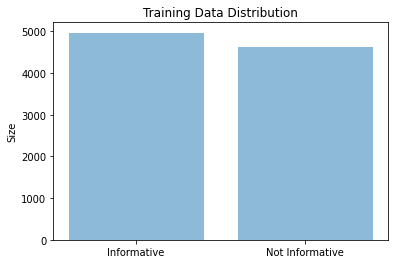

In [372]:
# Show plot for train data distribution

print("Train data distribution")

notinf_y_train = y_train[y_train == 1]
len_notinf = len(notinf_y_train)
print("Not Informative ",len_notinf)

inf_y_train = y_train[y_train == 0]
len_inf = len(inf_y_train)
print("Informative ",len_inf)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf,len_notinf]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Training Data Distribution')

plt.show()

Test data distribution
Not Informative  742
Informative  792


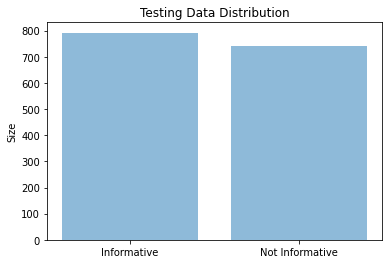

In [373]:
# Show plot for test data distribution

print("Test data distribution")

notinf_y_test = y_test[y_test == 1]
len_notinf_test = len(notinf_y_test)
print("Not Informative ",len_notinf_test)

inf_y_test = y_test[y_test == 0]
len_inf_test = len(inf_y_test)
print("Informative ",len_inf_test)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf_test,len_notinf_test]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Testing Data Distribution')

plt.show()

In [378]:
n_queries = 500 # number of query for uncertain dataset to be asked
n_initial = range(2000, 3001, n_queries)
repeats = 3 # number of repeat for each n_initial
seed = 20 # random seed

In [379]:
#result_rf_uncertainty, result_rf_acc_uncertainty, result_rf_time_uncertainty, experiment_uncertainty = random_forest_score_repeat(n_initial,n_queries,uncertainty_sampling,repeats,seed)
#print(experiment_uncertainty)


In [380]:
#result_rf_margin, result_rf_acc_margin, result_rf_time_margin, experiment_margin = random_forest_score_repeat(n_initial,n_queries,margin_sampling,repeats, seed)
#print(experiment_margin)

In [381]:
result_rf_entropy, result_rf_acc_entropy, result_rf_time_entropy, experiment_entropy = random_forest_score_repeat(n_initial,n_queries,entropy_sampling,repeats, seed)
print(experiment_entropy)

  0%|          | 0/3 [00:00<?, ?it/s]

0
[[0.58 0.42]
 [0.51 0.49]
 [0.45 0.55]
 ...
 [0.34 0.66]
 [0.35 0.65]
 [0.59 0.41]]
Experiment(n_samples=2000, repeat=0, accuracy=0.6160365058670143, log_loss=0.657586439860576)
[[0.55 0.45]
 [0.44 0.56]
 [0.56 0.44]
 ...
 [0.39 0.61]
 [0.43 0.57]
 [0.59 0.41]]
Experiment(n_samples=2500, repeat=0, accuracy=0.6127770534550195, log_loss=0.6579890173146544)


 33%|███▎      | 1/3 [00:46<01:33, 46.52s/it]

[[0.52 0.48]
 [0.56 0.44]
 [0.39 0.61]
 ...
 [0.38 0.62]
 [0.43 0.57]
 [0.46 0.54]]
Experiment(n_samples=3000, repeat=0, accuracy=0.6114732724902217, log_loss=0.6599784078446937)
1


 33%|███▎      | 1/3 [00:54<01:49, 54.94s/it]


KeyboardInterrupt: 

In [ ]:
#n_initial = range(30,300,30)
#seed_random = 20 # random seed
#repeat_random = 3 # number of repeat for each n_initial
#experiment_random, res_random, time_random = learning_curve(n_initial, repeat_random, random_sampling_policy,seed_random)
result_rf_random, result_rf_acc_random, result_rf_time_random, experiment_random = random_forest_score_repeat(n_initial,n_queries,random_sampling,repeats, seed)

In [ ]:
# show accuracy and log loss for each n_sample and repeat

#print(experiment_uncertainty)
#print(experiment_margin)
print(experiment_entropy)
print(experiment_random)

In [ ]:
# show accuracy plot

def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Active Learning vs Random Sampling Crisis MMD')
        plt.plot(training_sizes, p50, label=name )

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='lower right')
    plt.xlabel("Number of sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

#df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
#df_ms = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_es = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
#plot_learning_curve(df_us, "Uncertainty")
#plot_learning_curve(df_ms, "Margin")
plot_learning_curve(df_es, "Entropy")
plot_learning_curve(df_rs, "Random")

In [ ]:
# show log loss plot

def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['log_loss']
    p50 = df.groupby('n_samples').median()['log_loss']
    p90 = df.groupby('n_samples').quantile(.90)['log_loss']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Active Learning vs Random Sampling Crisis MMD')
        plt.plot(training_sizes, p50, label=name )

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)
    plt.legend(loc='upper right')
    plt.xlabel("Number of sample")
    plt.ylabel("Log Loss")
    plt.grid()
    #plt.show()

#df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiment_uncertainty])
#df_ms = pd.DataFrame([dataclasses.asdict(e) for e in experiment_margin])
df_es = pd.DataFrame([dataclasses.asdict(e) for e in experiment_entropy])
df_rs = pd.DataFrame([dataclasses.asdict(e) for e in experiment_random])
#plot_learning_curve(df_us, "Uncertainty")
#plot_learning_curve(df_ms, "Margin")
plot_learning_curve(df_es, "Entropy")
plot_learning_curve(df_rs, "Random")

In [326]:
# show precision, recall, f-1 score for final n_sample active learning

print(result_rf_uncertainty)
print(result_rf_margin)
print(result_rf_entropy)

print(result_rf_time_uncertainty)
print(result_rf_time_margin)
print(result_rf_time_entropy)

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       782
           1       0.54      0.48      0.51       752

    accuracy                           0.54      1534
   macro avg       0.54      0.54      0.54      1534
weighted avg       0.54      0.54      0.54      1534

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       782
           1       0.54      0.48      0.51       752

    accuracy                           0.54      1534
   macro avg       0.54      0.54      0.54      1534
weighted avg       0.54      0.54      0.54      1534

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       801
           1       0.49      0.47      0.48       733

    accuracy                           0.52      1534
   macro avg       0.52      0.52      0.52      1534
weighted avg       0.52      0.52      0.52      1534

9.222998142242432
1

In [283]:
# show precision, recall, f-1 score for final n_sample random sampling

print(res_random)
print(time_random)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        51
           1       0.82      0.98      0.89        42
           2       1.00      0.80      0.89        41
           3       0.83      0.97      0.90        40
           4       0.98      0.94      0.96        52
           5       1.00      0.79      0.88        48
           6       0.98      0.98      0.98        48
           7       0.89      1.00      0.94        41
           8       0.88      0.82      0.85        45
           9       0.77      0.81      0.79        42

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.92      0.91      0.91       450

3.190356731414795
